In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

import itertools as it
from collections import Counter, defaultdict, deque

In [4]:
cd ..

/home/fredcallaway/mcrl/risky_choice


In [5]:
import json
df = pd.read_csv('data/03242018/trials.csv', index_col=0)
for col in ['outcome_probs', 'ground_truth', 'clicks']:
    df[col] = df[col].apply(json.loads)

In [10]:
cd ../python

/home/fredcallaway/mcrl/python


In [11]:
from oldmouselab import OldMouselabEnv
from distributions import TruncatedNormal
from policies import LiederPolicy
from evaluation import read_ombo_policy
from agents import Agent

N_GAMBLE = 7
N_OUTCOME = 4
N_CELL = N_GAMBLE * N_OUTCOME

In [12]:
from tqdm import tqdm

def expand(row_idx):
    def loop():
        for i, row in df.iloc[list(row_idx)].iterrows():
            env = OldMouselabEnv(
                N_GAMBLE, row.outcome_probs, cost=.01, ground_truth=row.ground_truth,
                reward=TruncatedNormal(row.reward_mu, row.reward_sigma, 0.01,9.99)
            )
            pol = read_ombo_policy(row.reward_mu, row.reward_sigma, row.outcome_probs)
            agent = Agent()
            agent.register(env)
            agent.register(pol)

            for a in [*row.clicks, env.term_action]:
                prefs = np.array([pol.preference(a) for a in range(N_CELL + 1)])
                prefs -= prefs.max()

                yield {'action': a, 'state': env._state, 'prefs': prefs,
                       'workerid': row.workerid, 'trial_index': row.trial_index}
                env.step(a)
    return pd.DataFrame(loop())

from toolz import partition_all
chunks = list(partition_all(10, range(len(df))))

from joblib import Parallel, delayed
jobs = tqdm([delayed(expand)(c) for c in chunks])
results = Parallel(30)(jobs)
action_df = pd.concat(results)

 32%|███▏      | 63/200 [00:12<00:27,  5.01it/s]/home/fredcallaway/miniconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
 48%|████▊     | 95/200 [01:03<01:09,  1.50it/s]/home/fredcallaway/miniconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
 77%|███████▋  | 154/200 [02:20<00:42,  1.09it/s]/home/fredcallaway/miniconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
100%|██████████| 200/200 [03:32<00:00,  1.06s/it]


In [47]:
def n_options(prefs):
    return np.sum(prefs > -90)

action_df['n_options'] = action_df.prefs.apply(n_options)
action_df['p_rand'] = 1 / action_df.n_options.as_matrix()

In [48]:
def opt_actions(prefs, tol=.01):
    return prefs > -tol

def optimal_likelihood(row):
    opt_acts = opt_actions(row.prefs)
    return opt_acts[row.action] / opt_acts.sum()
    

action_df['p_opt'] = action_df.apply(optimal_likelihood, axis=1)

In [49]:
def epsilon_greedy_loglike(data, eps):
    like = eps * data.p_rand.as_matrix() + (1-eps) * data.p_opt.as_matrix()
    return np.log(like).sum(-1)

def max_likelihood(data):
    eps = np.linspace(0,0.5)[1:]
    logp = epsilon_greedy_loglike(data, eps[:, None])
    
    best_idx = np.argmax(logp)
    return {'eps': eps[best_idx], 
            'p_opt': logp[best_idx], 
            'baseline': epsilon_greedy_loglike(data, 1)}

ind_results = action_df.groupby('workerid').apply(max_likelihood)
ind_results = pd.DataFrame(list(ind_results), index=ind_results.index)

# np.exp(logp / len(action_df))

In [55]:
len(ind_results)

100

In [58]:
(ind_results
 .rename(columns={'p_opt': 'log_likelihood', 'eps': 'epsilon'})
 .to_csv('~/mcrl/risky_choice/results/RR_individual_mle.csv')
)

/home/fredcallaway/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


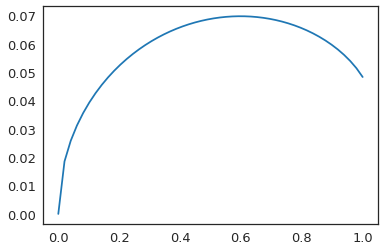

In [46]:
eps = np.linspace(0,1)
logp = epsilon_greedy_loglike(action_df, eps[:, None])
likelihood = np.exp(logp / len(action_df))
plt.plot(eps, likelihood)

In [200]:
prefs = np.stack(action_df.prefs)
opt_acts = opt_actions(prefs)
action_df['click_is_opt'] = opt_acts[:, :-1].any(1)
action_df['term_is_opt'] = opt_acts[:, -1]

In [201]:
action_df['term_action'] = action_df.action == 28
action_df['optimal'] = action_df.p_opt > 0
action_df.optimal.mean()

0.51040108769544523

In [199]:
action_df.groupby(['term_action', 'term_is_opt']).optimal.mean().unstack()

term_is_opt,False,True
term_action,,
False,0.592786,0.221908
True,0.000000,1.000000


In [257]:
tbl = dd.groupby(['term_action', 'term_is_opt']).apply(len) / len(dd)
print(tbl.get((1, 0), 0),'  ', tbl.get((0, 1), 0))

0    1.0


In [ ]:
1

In [258]:
errors = action_df.query('not optimal').copy()
for (d, s), dd in errors.groupby(['dispersion', 'stakes']):
    print(f'{d} dispersion  {s} stakes\n')
    tbl = dd.groupby(['term_action', 'term_is_opt']).apply(len) / len(dd)
    print(tbl.get((1, 0), 0),'  ', tbl.get((0, 1), 0))
    print('\n')

high dispersion  high stakes

0.103977272727    0.441477272727


high dispersion  low stakes

0.483957219251    0.371657754011


low dispersion  high stakes

0.0947765212709    0.128971459343


low dispersion  low stakes

0    1.0




In [191]:
df = df.set_index(['workerid', 'trial_index'])
action_df = action_df.set_index(['workerid', 'trial_index'])
df['stakes'] = df.reward_mu.apply(lambda x: 'high' if x == 5.0 else 'low')
df['dispersion'] = df.outcome_probs.apply(lambda x: 'high' if np.max(x) >= 0.85 else 'low')
for c in 'stakes', 'dispersion':
    action_df[c] = df[c]

0.3816995279089142